In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
ROOT_PATH = '/content/drive/My Drive/SyntheticImageDetection/rule_based/'.replace(" ", "\\ ")

Mounted at /content/drive


In [ ]:
import torch
%run {ROOT_PATH + 'data_dif.ipynb'}
%run {ROOT_PATH + 'trainer_dif.ipynb'}
%run {ROOT_PATH + 'utils.ipynb'}
import pickle
from pathlib import Path

Exception: File `'/content/drive/My Drive/SyntheticImageDetection/rule_based/data_dif.ipynb.py'` not found.

In [ ]:
class GenerativeModel(TrainerMultiple):
    def __init__(self, fingerprint_dir, epoch=0, batch=64):
        model_ep = epoch
        check_dir = Path(fingerprint_dir)
        check_existence(check_dir, False)
        with open(check_dir / "train_hypers.pt", 'rb') as pickle_file:
            hyperparams = pickle.load(pickle_file)
        hyperparams['Device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        hyperparams['Batch Size'] = batch
        super().__init__(hyperparams)
        self.load_stats(check_dir / f"chk_{model_ep}.pt")


    def denoise_image(self, img_path):
        image = load_pil_image(img_path, self.crop_size)
        image = np.array(image)

        image = torch.tensor(image.transpose((2, 0, 1))).type(torch.float32).div(255)
        image = image.unsqueeze(0)

        residuals = self.denoiser.denoise(image.to(self.device)).detach()
        # alpha = (1 - self.alpha) * torch.rand((len(image), 1, 1, 1)).to(self.device) + self.alpha
        # residuals = alpha * residuals
        return residuals


    def get_correlation(self, img_path):
        image = load_pil_image(img_path, self.crop_size)
        image = np.array(image)

        image = torch.tensor(image.transpose((2, 0, 1))).type(torch.float32).div(255)
        image = image.unsqueeze(0)  # Adding batch size of 1

        residuals = self.denoiser.denoise(image.to(self.device)).detach()
        # alpha = (1 - self.alpha) * torch.rand((len(image), 1, 1, 1)).to(self.device) + self.alpha
        # residuals = alpha * residuals
        corr = self.corr_fun(self.fingerprint, residuals)
        corr = corr.mean((1, 2, 3))
        return corr


    def show_residul(self, image):
        image = 0.5 * image + 0.5
        image = image.cpu().detach().numpy()  # Move tensor to CPU, detach, and convert to numpy
        image = image.squeeze().transpose((1, 2, 0))  # Reshape the image for display
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Residual')
        plt.show()
        # Assuming produce_spectrum works with numpy arrays
        dct_finger = produce_spectrum(image)
        dct_finger = (dct_finger - dct_finger.min()) / (dct_finger.max() - dct_finger.min())
        plt.figure(figsize=(4, 4))
        plt.imshow(dct_finger, 'bone')
        plt.axis('off')
        plt.title('Residual FFT')
        plt.show()

In [ ]:
def load_pil_image(img_path, img_size=None):
    img = Image.open(img_path).convert('RGB')

    if img_size is not None:
        w, h = img.size
        left = (w - img_size[1]) / 2
        top = (h - img_size[0]) / 2
        right = (w + img_size[1]) / 2
        bottom = (h + img_size[0]) / 2

        img = img.crop((left, top, right, bottom))

    return img

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image from file
fake_image_to_detect_path = Path('/content/drive/My Drive/SyntheticImageDetection/data/synthetic_images/glide/img000336.jpg')
# fake_image_to_detect_path = Path('/content/drive/My Drive/SyntheticImageDetection/data/synthetic_images/glide/img000660.jpg')


# fake_image_to_detect_path = Path(ROOT_PATH + 'data/glide/1_fake/img_1038562.png')
image_to_detect = mpimg.imread(fake_image_to_detect_path)

# Display the image
plt.imshow(image_to_detect)
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
glide_model = GenerativeModel(fingerprint_dir='/content/drive/My Drive/SyntheticImageDetection/checks_stylegan3', epoch=300)

device cpu


In [ ]:
np.mean(glide_model.train_corr_r)
np.median(glide_model.train_corr_r)

-0.14511980413417902

In [ ]:
np.mean(glide_model.train_corr_f)
np.median(glide_model.train_corr_f)


-0.07491552365496199

In [ ]:
image_to_detect_corr = glide_model.get_correlation(fake_image_to_detect_path)
image_to_detect_corr

tensor([-0.0402], dtype=torch.float64)

In [ ]:
image_to_detect_corr.shape

torch.Size([1])

In [ ]:
image_to_detect_res = glide_model.denoise_image(fake_image_to_detect_path)

In [ ]:
image_to_detect_res.shape

torch.Size([1, 3, 256, 256])

In [ ]:
glide_model.fingerprint.shape

torch.Size([1, 3, 256, 256])

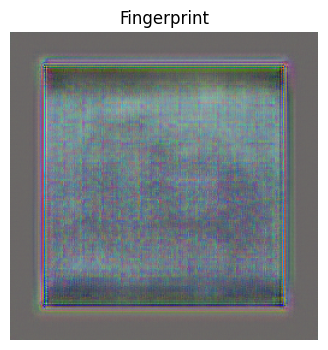

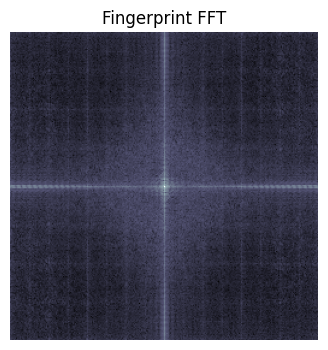

In [ ]:
glide_model.show_fingerprint()

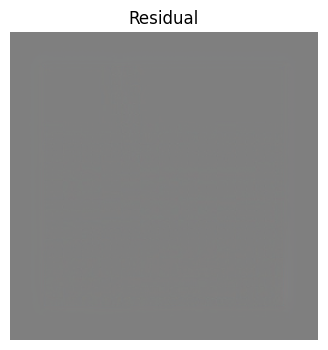

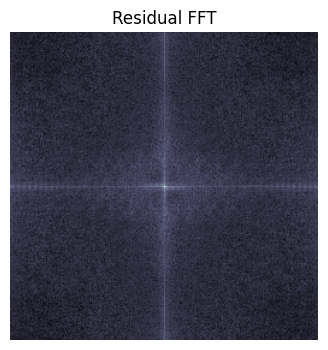

In [ ]:
glide_model.show_residul(image_to_detect_res)

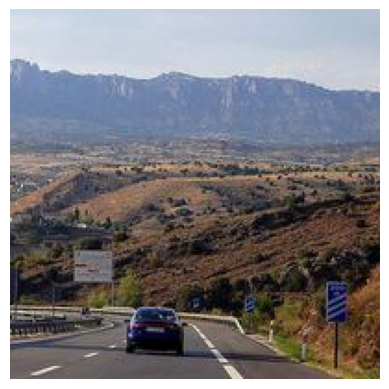

In [ ]:
# real_image_to_detect_path = Path('/content/drive/My Drive/SyntheticImageDetection/data/real_images/landscape/img004316.jpg')
real_image_to_detect_path = Path('/content/drive/My Drive/SyntheticImageDetection/data/real_images/landscape/img004292.jpg')

image_to_detect = mpimg.imread(real_image_to_detect_path)

# Display the image
plt.imshow(image_to_detect)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
real_image_to_detect_corr = glide_model.get_correlation(real_image_to_detect_path)
real_image_to_detect_corr

tensor([-0.1404], dtype=torch.float64)

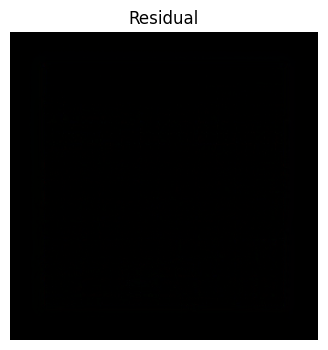

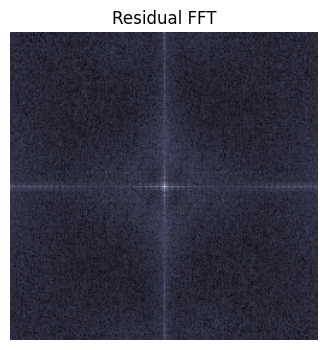

In [ ]:
image_to_detect_residual = glide_model.denoise_image(real_image_to_detect_path)
glide_model.show_residul(image_to_detect_residual)